In [56]:
# Dependencies and Setup
#%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats

In [65]:
# Import data to convert text fields to categorical fields
data = pd.read_csv("train.csv")
getfields = data[["LotArea", "OverallQual", "YearRemodAdd", "TotalBsmtSF", "GrLivArea", "SalePrice" ]]
formodel["LotArea"] = getfields["LotArea"] /10000
formodel["OverallQual"] = getfields["OverallQual"]
formodel["YearRemodAdd"] = getfields["YearRemodAdd"] /100
formodel["TotalBsmtSF"] = getfields["TotalBsmtSF"] /1000
formodel["GrLivArea"] = getfields["GrLivArea"] /1000
formodel["SalePrice"] = getfields["SalePrice"] /10000
formodel["ln_SalePrice"] = np.log(getfields["SalePrice"] /10000)
formodel.describe()

,LotArea,OverallQual,YearRemodAdd,TotalBsmtSF,GrLivArea,SalePrice,Pred1,Pred2,ln_SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.00000,1460.000000,1460.000000,1460.000000
mean,1.051683,6.099315,19.848658,1.057429,1.515464,18.09212,18.134160,18.092120,2.813711
std,0.998126,1.382997,0.206454,0.438705,0.525480,7.94425,6.742325,6.922557,0.399452
min,0.130000,1.000000,19.500000,0.000000,0.334000,3.49000,5.146923,-5.612399,1.249902
25%,0.755350,5.000000,19.670000,0.795750,1.129500,12.99750,13.294764,13.070209,2.564757
50%,0.947850,6.000000,19.940000,0.991500,1.464000,16.30000,16.539182,17.599321,2.791165
75%,1.160150,7.000000,20.040000,1.298250,1.776750,21.40000,21.569263,22.295122,3.063391
max,21.524500,10.000000,20.100000,6.110000,5.642000,75.50000,70.847395,68.583359,4.324133


In [76]:
# Create formula (form1) for use in linear models
a = formodel.columns[0]
b = formodel.columns[1]
c = formodel.columns[2]
d = formodel.columns[3]
e = formodel.columns[4]

form1 = "SalePrice ~ " + a + " + " +  b + " + " + c + " + " + d + " + " + e
form2 = "ln_SalePrice ~ " + a + " + " +  b + " + " + c + " + " + d + " + " + e
form2

'ln_SalePrice ~ LotArea + OverallQual + YearRemodAdd + TotalBsmtSF + GrLivArea'

In [77]:
# GLM consistent with Ordinary least squares --- sm.families.links.log
model_ols = smf.glm(formula = form1, data = formodel, family = sm.families.Gaussian(sm.families.links.log)).fit()
print(model_ols.summary())
ols_test = smf.ols(formula = form2, data = formodel).fit()
print(ols_test.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1460
Model:                            GLM   Df Residuals:                     1454
Model Family:                Gaussian   Df Model:                            5
Link Function:                    log   Scale:                          16.184
Method:                          IRLS   Log-Likelihood:                -4101.0
Date:                Thu, 25 Jul 2019   Deviance:                       23531.
Time:                        18:52:29   Pearson chi2:                 2.35e+04
No. Iterations:                    18   Covariance Type:             nonrobust
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -5.1992      0.754     -6.899      0.000      -6.676      -3.722
LotArea          0.0241      0.004      5.718 

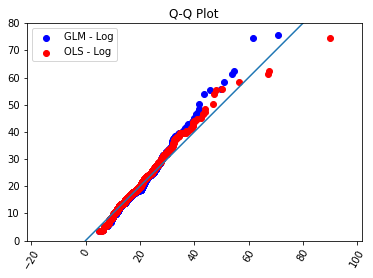

In [78]:
formodel["Pred1"] = model_ols.predict()
formodel["Pred2"] = np.exp(ols_test.predict())
min = 0
max = 80
plt.scatter(np.sort(formodel["Pred1"]),np.sort(formodel["SalePrice"]),color="blue",label="GLM - Log")
plt.scatter(np.sort(formodel["Pred2"]),np.sort(formodel["SalePrice"]),color="red",label="OLS - Log")
plt.legend()
plt.plot([0,max],[0,max])

plt.axis("equal")
plt.title("Q-Q Plot")
plt.xticks(rotation = 60)
plt.xlim(min,max)
plt.ylim(min,max)

plt.show()

In [69]:
A = np.identity(len(model_ols.params))
A = A[1:,:]
print(model_ols.f_test(A))

<F test: F=array([[973.87924557]]), p=0.0, df_denom=1454, df_num=5>


In [70]:
num_samples = 1000
glm_params = np.zeros((num_samples,6),dtype=float)
sample_rows = len(formodel["SalePrice"])

for i in range(num_samples):
    seed = 12345 + i
    sampled = formodel.sample(n=sample_rows,replace = True, random_state = seed)
    model_ols = smf.glm(formula = form1, data = sampled, family = sm.families.Gaussian(sm.families.links.log)).fit()
    for j in range(6):
        glm_params[i,j] = model_ols.params[j]
df_boot = pd.DataFrame(glm_params)
df_boot.columns = ["Intercept", a, b, c, d, e]
#df_boot.head()

In [71]:
df_boot.describe()

,Intercept,LotArea,OverallQual,YearRemodAdd,TotalBsmtSF,GrLivArea
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-5.480133,0.021832,0.166301,0.352578,0.027714,0.165258
std,0.877250,0.015482,0.025833,0.044798,0.098532,0.043795
min,-8.159866,-0.114350,0.098011,0.223132,-0.133193,0.052502
25%,-6.026692,0.020528,0.143574,0.322800,-0.045927,0.135855
50%,-5.451207,0.024737,0.176199,0.351601,-0.016353,0.160989
75%,-4.891966,0.028332,0.184898,0.381439,0.123918,0.187910
max,-3.054660,0.082543,0.210909,0.487629,0.246469,0.282566
